# comparing interpolation and reprojection approaches

this notebook compares two approaches for reprojecting and interpolating the USFS fire risk data from 270m (EPSG:5070) to 30m (EPSG:4326):

1. **option 1**: reproject first (270m EPSG:5070 → 270m EPSG:4326), then interpolate to 30m
2. **option 2**: reproject first, then regrid using xesmf

we'll test both on a region around (47.35914, -120.16034) to see how they preserve the unburnable mask.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import xesmf as xe
from odc.geo.xr import assign_crs, xr_reproject

from ocr import catalog

## load original 270m data in EPSG:5070

In [2]:
lat = 47.35914
lng = -120.16034

# load 270m data
usfs_270 = catalog.get_dataset('2011-climate-run').to_xarray()

# transform lat/lng to EPSG:5070
transformer = pyproj.Transformer.from_crs('EPSG:4326', usfs_270.spatial_ref.crs_wkt, always_xy=True)
x, y = transformer.transform(lng, lat)

# subset around the point (30km buffer)
subset_270 = usfs_270.sel(x=slice(x - 30000, x + 30000), y=slice(y + 30000, y - 30000))
print(f'original 270m data shape: {subset_270.BP.shape}')
subset_270

original 270m data shape: (222, 222)


<xarray.Dataset> Size: 3MB
Dimensions:      (y: 222, x: 222)
Coordinates:
  * x            (x) float64 2kB -1.846e+06 -1.846e+06 ... -1.787e+06 -1.786e+06
  * y            (y) float64 2kB 2.969e+06 2.969e+06 ... 2.91e+06 2.91e+06
Data variables:
    FLP4         (y, x) float64 394kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP3         (y, x) float64 394kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP2         (y, x) float64 394kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    spatial_ref  int64 8B ...
    BP           (y, x) float64 394kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP6         (y, x) float64 394kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP1         (y, x) float64 394kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP5         (y, x) float64 394kB dask.array<chunksize=(222, 222), meta=np.ndarray>

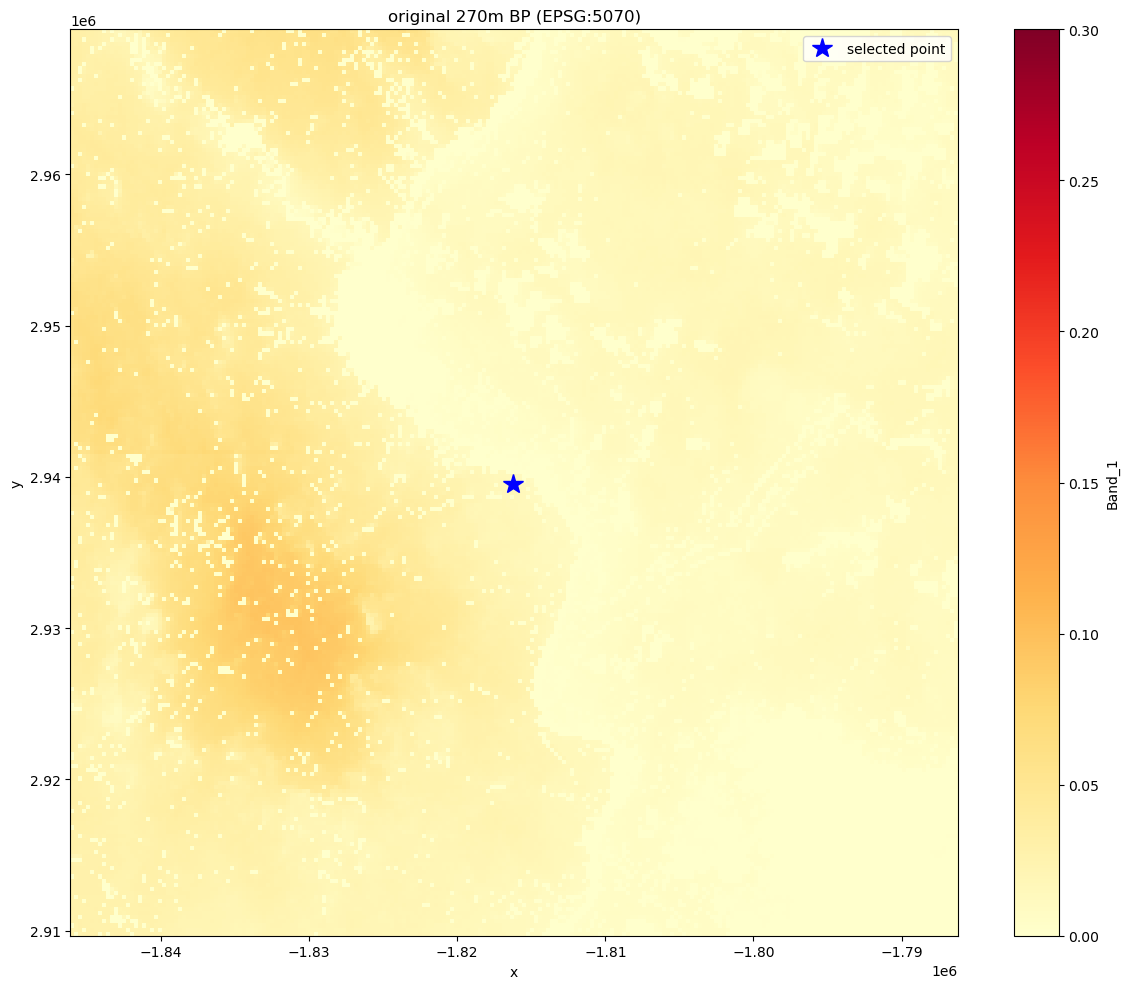

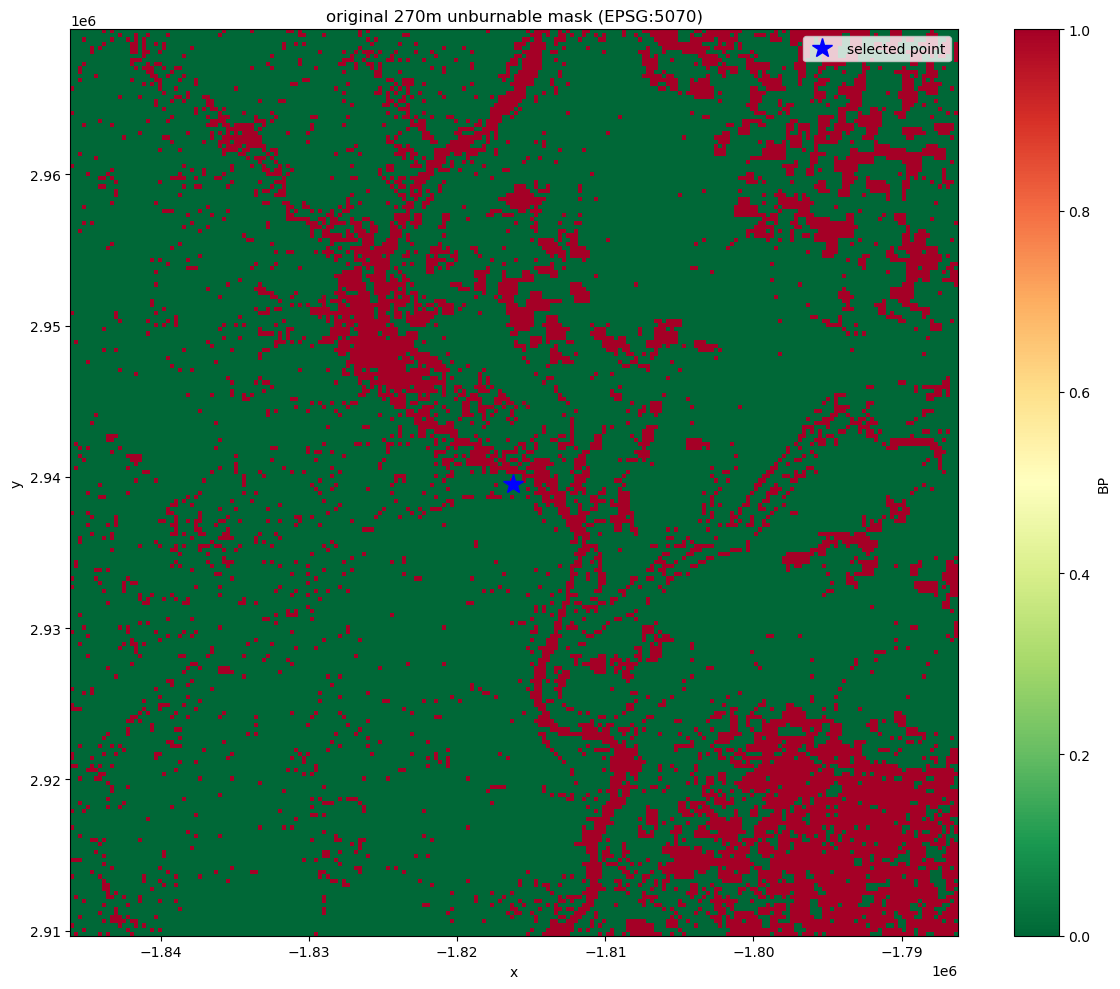

In [3]:
# visualize original 270m data
fig, ax = plt.subplots(figsize=(12, 10))
subset_270.BP.plot(ax=ax, cmap='YlOrRd', vmin=0, vmax=0.3, robust=True)
ax.plot(x, y, 'b*', markersize=15, label='selected point')
ax.set_title('original 270m BP (EPSG:5070)')
ax.legend()
plt.tight_layout()
plt.show()

# show unburnable mask
unburnable_original = subset_270.BP == 0
fig, ax = plt.subplots(figsize=(12, 10))
unburnable_original.plot(ax=ax, cmap='RdYlGn_r', add_colorbar=True)
ax.plot(x, y, 'b*', markersize=15, label='selected point')
ax.set_title('original 270m unburnable mask (EPSG:5070)')
ax.legend()
plt.tight_layout()
plt.show()

## option 1: reproject first, then interpolate with interp_like

In [4]:
# assign crs and reproject to EPSG:4326
subset_270_crs = assign_crs(subset_270, crs='EPSG:5070')
subset_270_4326 = xr_reproject(subset_270_crs, how='EPSG:4326')

print(f'reprojected 270m data shape: {subset_270_4326.BP.shape}')
subset_270_4326

reprojected 270m data shape: (223, 324)


<xarray.Dataset> Size: 4MB
Dimensions:      (latitude: 223, longitude: 324)
Coordinates:
  * latitude     (latitude) float64 2kB 47.69 47.69 47.69 ... 47.03 47.03 47.03
  * longitude    (longitude) float64 3kB -120.6 -120.6 -120.6 ... -119.7 -119.7
    spatial_ref  int32 4B 4326
Data variables:
    FLP4         (latitude, longitude) float64 578kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP3         (latitude, longitude) float64 578kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP2         (latitude, longitude) float64 578kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    BP           (latitude, longitude) float64 578kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP6         (latitude, longitude) float64 578kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP1         (latitude, longitude) float64 578kB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP5         (latitude, longitude) float64 578kB dask.array<chunksize=(222, 222), meta=np.ndarray>

In [9]:
# create 30m reference grid for this region
rps_30_4326 = catalog.get_dataset('USFS-wildfire-risk-communities-4326').to_xarray()
rps_30_subset = rps_30_4326.sel(
    latitude=slice(lat + 0.3, lat - 0.3), longitude=slice(lng - 0.3, lng + 0.3)
)

print(f'30m reference grid shape: {rps_30_subset.BP.shape}')
rps_30_subset

30m reference grid shape: (1949, 1948)


<xarray.Dataset> Size: 122MB
Dimensions:      (latitude: 1949, longitude: 1948)
Coordinates:
  * latitude     (latitude) float64 16kB 47.66 47.66 47.66 ... 47.06 47.06 47.06
  * longitude    (longitude) float64 16kB -120.5 -120.5 -120.5 ... -119.9 -119.9
Data variables:
    CFL          (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    Exposure     (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    FLEP4        (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    BP           (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    CRPS         (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    FLEP8        (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    RPS          (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    WHP          (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1262), meta=np.ndarray>
    spatial_ref  int32 4B ...
Attributes:
    title:        RDS-2020-0016-02
    version:      2024-V2
    data_source:  https://www.fs.usda.gov/rds/archive/catalog/RDS-2020-0016-
    description:  ['Modified version of: Wildfire Risk to Communities: Spatia...
    EPSG:         4326
    resolution:   30m

## current (production): interpolate first, then reproject

In [18]:
# load 30m reference for EPSG:5070
current_30_4326 = catalog.get_dataset('2011-climate-run-30m-4326').to_xarray()

# subset to match our region
current_30_4326_subset = current_30_4326.sel(
    latitude=slice(lat + 0.3, lat - 0.3), longitude=slice(lng - 0.3, lng + 0.3)
)


print(f'current final shape: {current_30_4326_subset.BP.shape}')
current_30_4326_subset

current final shape: (1949, 1948)


<xarray.Dataset> Size: 106MB
Dimensions:      (latitude: 1949, longitude: 1948)
Coordinates:
  * latitude     (latitude) float64 16kB 47.66 47.66 47.66 ... 47.06 47.06 47.06
  * longitude    (longitude) float64 16kB -120.5 -120.5 -120.5 ... -119.9 -119.9
Data variables:
    FLP3         (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1948), meta=np.ndarray>
    FLP2         (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1948), meta=np.ndarray>
    FLP6         (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1948), meta=np.ndarray>
    BP           (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1948), meta=np.ndarray>
    FLP4         (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1948), meta=np.ndarray>
    spatial_ref  int32 4B ...
    FLP5         (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1948), meta=np.ndarray>
    FLP1         (latitude, longitude) float32 15MB dask.array<chunksize=(1949, 1948), meta=np.ndarray>
Attributes:
    title:        RDS-2025-0006
    version:      2025
    data_source:  https://www.fs.usda.gov/rds/archive/catalog/RDS-2025-0006
    description:  Modified version of: Spatial datasets of probabilistic wild...
    EPSG:         4326
    resolution:   30m

/tmp/ipykernel_17533/174088092.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


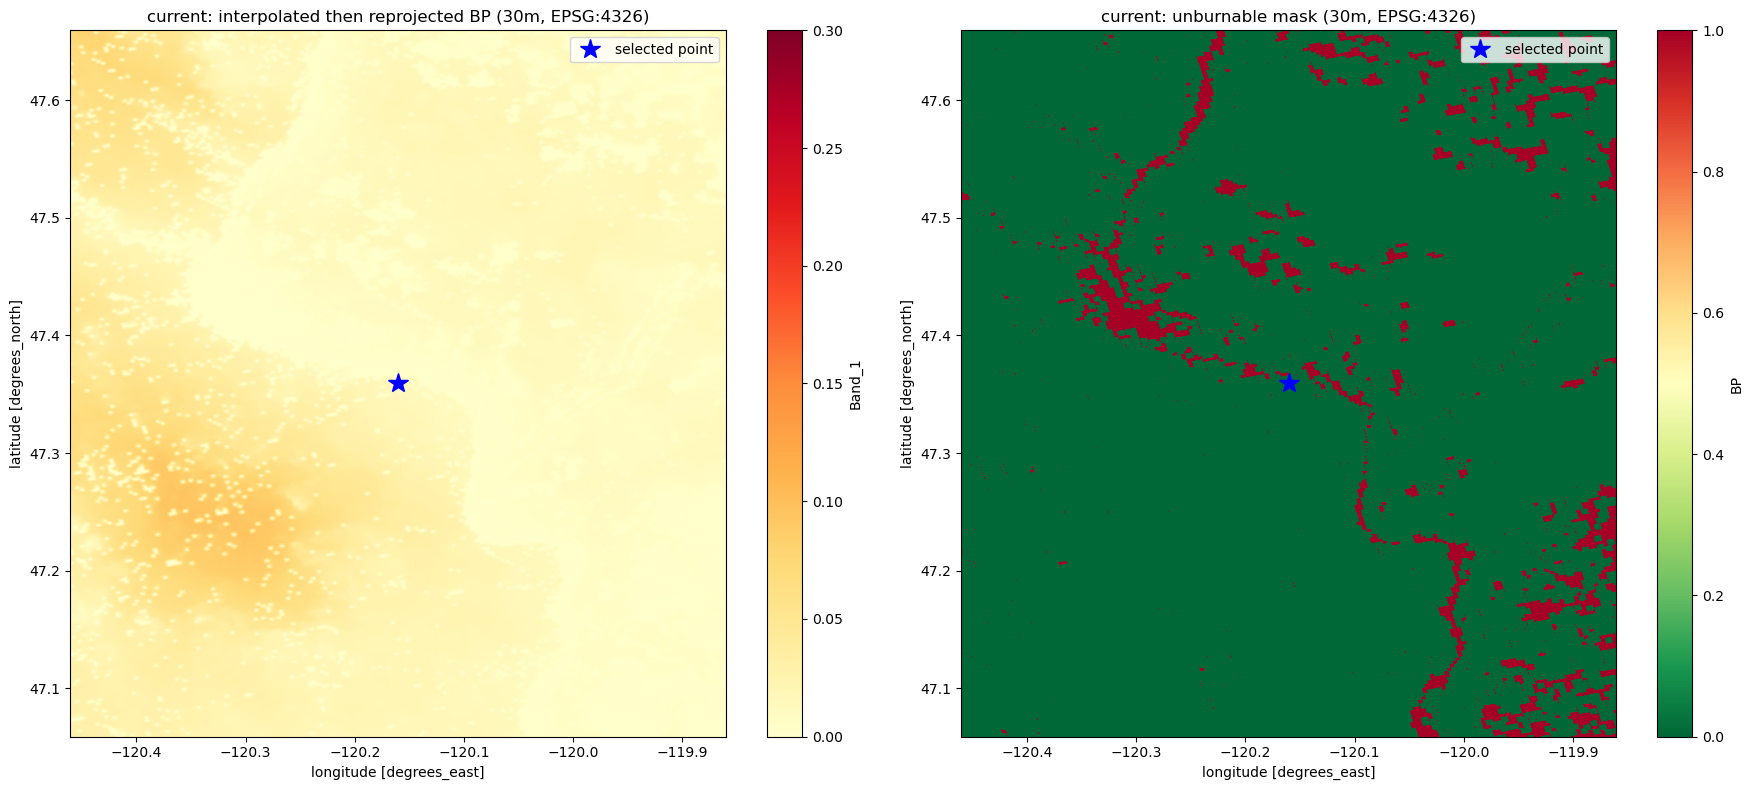

In [7]:
# visualize current results
unburnable_mask_current = current_30_4326_subset.BP == 0

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# BP values
current_30_4326_subset.BP.plot(ax=axes[0], cmap='YlOrRd', vmin=0, vmax=0.3)
axes[0].plot(lng, lat, 'b*', markersize=15, label='selected point')
axes[0].set_title('current: interpolated then reprojected BP (30m, EPSG:4326)')
axes[0].legend()

# unburnable mask
unburnable_mask_current.plot(ax=axes[1], cmap='RdYlGn_r', add_colorbar=True)
axes[1].plot(lng, lat, 'b*', markersize=15, label='selected point')
axes[1].set_title('current: unburnable mask (30m, EPSG:4326)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [10]:
# interpolate to 30m with fill_value=np.nan
option1_30_4326 = subset_270_4326.interp_like(
    rps_30_subset, kwargs={'fill_value': np.nan, 'bounds_error': False}
)

# create unburnable mask after interpolation
unburnable_mask_option1 = option1_30_4326.BP == 0

# ensure unburnable areas stay at 0
option1_30_4326 = option1_30_4326.where(~unburnable_mask_option1, 0)
option1_30_4326 = option1_30_4326.clip(min=0)

print(f'option 1 final shape: {option1_30_4326.BP.shape}')
option1_30_4326

option 1 final shape: (1949, 1948)


<xarray.Dataset> Size: 213MB
Dimensions:      (latitude: 1949, longitude: 1948)
Coordinates:
    spatial_ref  int32 4B 4326
  * latitude     (latitude) float64 16kB 47.66 47.66 47.66 ... 47.06 47.06 47.06
  * longitude    (longitude) float64 16kB -120.5 -120.5 -120.5 ... -119.9 -119.9
Data variables:
    FLP4         (latitude, longitude) float64 30MB dask.array<chunksize=(650, 1948), meta=np.ndarray>
    FLP3         (latitude, longitude) float64 30MB dask.array<chunksize=(650, 1948), meta=np.ndarray>
    FLP2         (latitude, longitude) float64 30MB dask.array<chunksize=(650, 1948), meta=np.ndarray>
    BP           (latitude, longitude) float64 30MB dask.array<chunksize=(650, 1948), meta=np.ndarray>
    FLP6         (latitude, longitude) float64 30MB dask.array<chunksize=(650, 1948), meta=np.ndarray>
    FLP1         (latitude, longitude) float64 30MB dask.array<chunksize=(650, 1948), meta=np.ndarray>
    FLP5         (latitude, longitude) float64 30MB dask.array<chunksize=(650, 1948), meta=np.ndarray>

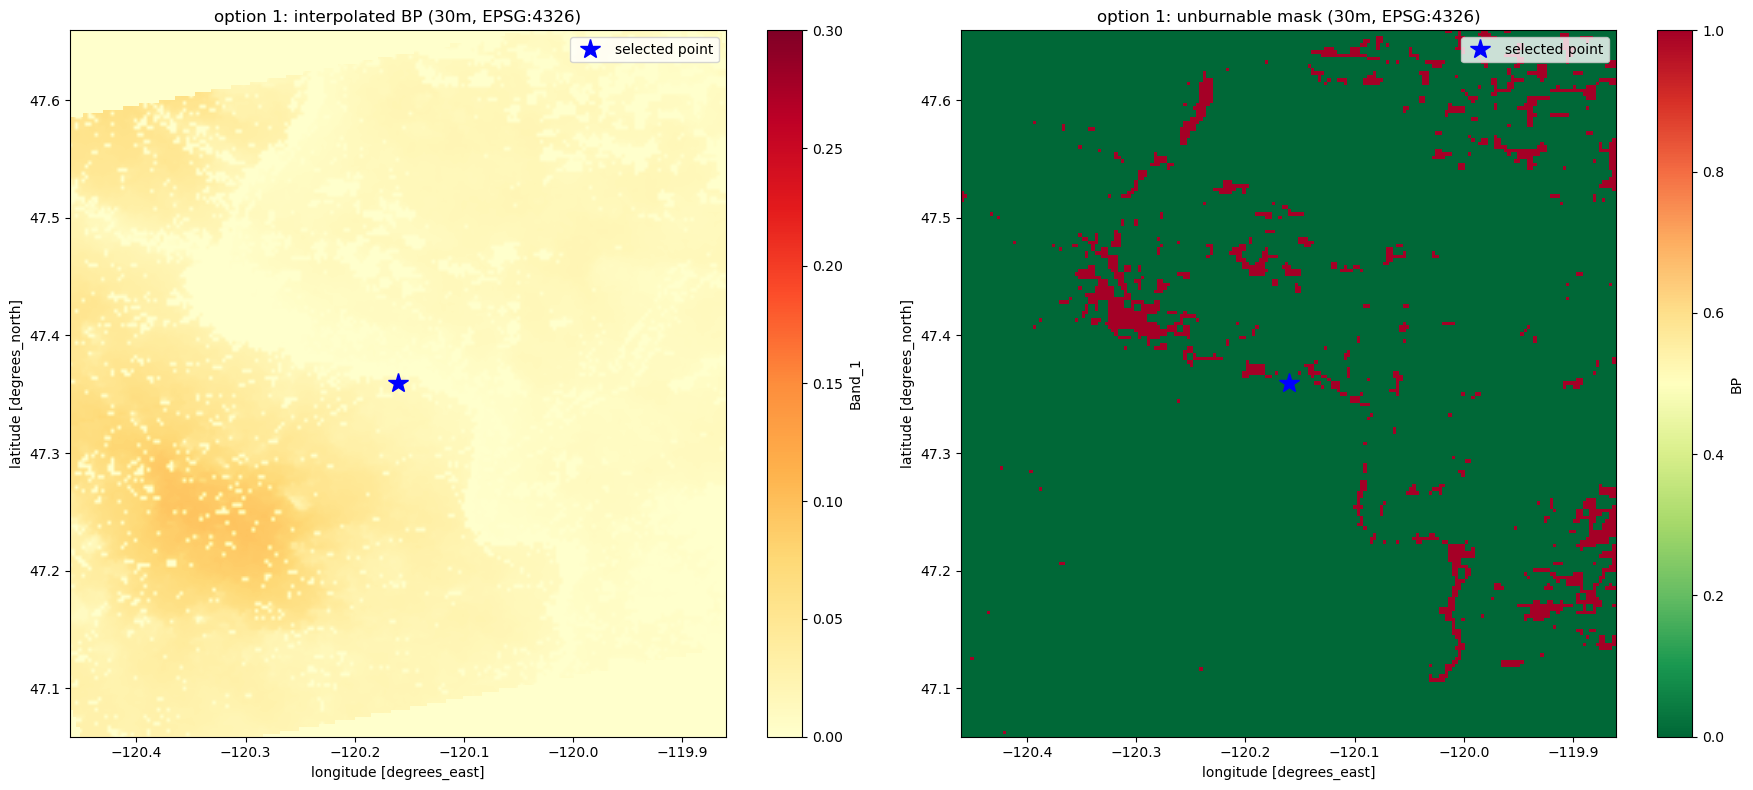

In [11]:
# visualize option 1 results
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# BP values
option1_30_4326.BP.plot(ax=axes[0], cmap='YlOrRd', vmin=0, vmax=0.3)
axes[0].plot(lng, lat, 'b*', markersize=15, label='selected point')
axes[0].set_title('option 1: interpolated BP (30m, EPSG:4326)')
axes[0].legend()

# unburnable mask
unburnable_mask_option1.plot(ax=axes[1], cmap='RdYlGn_r', add_colorbar=True)
axes[1].plot(lng, lat, 'b*', markersize=15, label='selected point')
axes[1].set_title('option 1: unburnable mask (30m, EPSG:4326)')
axes[1].legend()

plt.tight_layout()
plt.show()

## option 2: reproject first, then regrid with xesmf

In [12]:
# use the same reprojected 270m data
# create regridder
regridder = xe.Regridder(subset_270_4326, rps_30_subset, 'bilinear', extrap_method='nearest_s2d')

# regrid to 30m
option2_30_4326 = regridder(subset_270_4326)

# create unburnable mask after regridding
unburnable_mask_option2 = option2_30_4326.BP == 0

# ensure unburnable areas stay at 0
option2_30_4326 = option2_30_4326.where(~unburnable_mask_option2, 0)
option2_30_4326 = option2_30_4326.clip(min=0)

print(f'option 2 final shape: {option2_30_4326.BP.shape}')
option2_30_4326

option 2 final shape: (1949, 1948)


<xarray.Dataset> Size: 213MB
Dimensions:      (latitude: 1949, longitude: 1948)
Coordinates:
    spatial_ref  int32 4B 4326
  * latitude     (latitude) float64 16kB 47.66 47.66 47.66 ... 47.06 47.06 47.06
  * longitude    (longitude) float64 16kB -120.5 -120.5 -120.5 ... -119.9 -119.9
Data variables:
    FLP4         (latitude, longitude) float64 30MB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP3         (latitude, longitude) float64 30MB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP2         (latitude, longitude) float64 30MB dask.array<chunksize=(222, 222), meta=np.ndarray>
    BP           (latitude, longitude) float64 30MB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP6         (latitude, longitude) float64 30MB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP1         (latitude, longitude) float64 30MB dask.array<chunksize=(222, 222), meta=np.ndarray>
    FLP5         (latitude, longitude) float64 30MB dask.array<chunksize=(222, 222), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

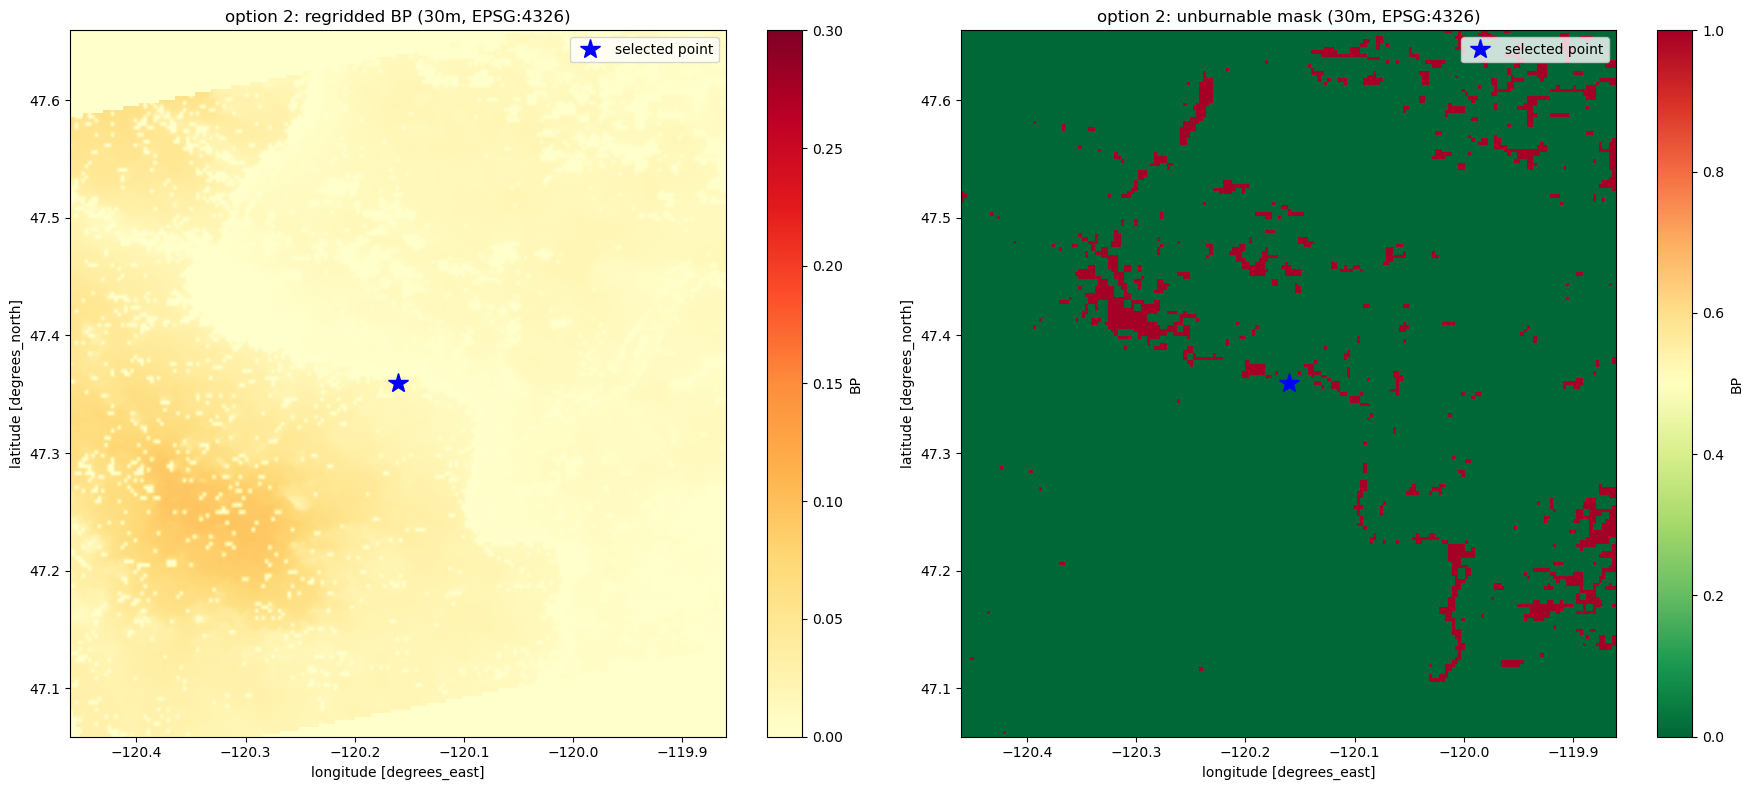

In [13]:
# visualize option 2 results
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# BP values
option2_30_4326.BP.plot(ax=axes[0], cmap='YlOrRd', vmin=0, vmax=0.3)
axes[0].plot(lng, lat, 'b*', markersize=15, label='selected point')
axes[0].set_title('option 2: regridded BP (30m, EPSG:4326)')
axes[0].legend()

# unburnable mask
unburnable_mask_option2.plot(ax=axes[1], cmap='RdYlGn_r', add_colorbar=True)
axes[1].plot(lng, lat, 'b*', markersize=15, label='selected point')
axes[1].set_title('option 2: unburnable mask (30m, EPSG:4326)')
axes[1].legend()

plt.tight_layout()
plt.show()

## side-by-side comparison (all approaches)

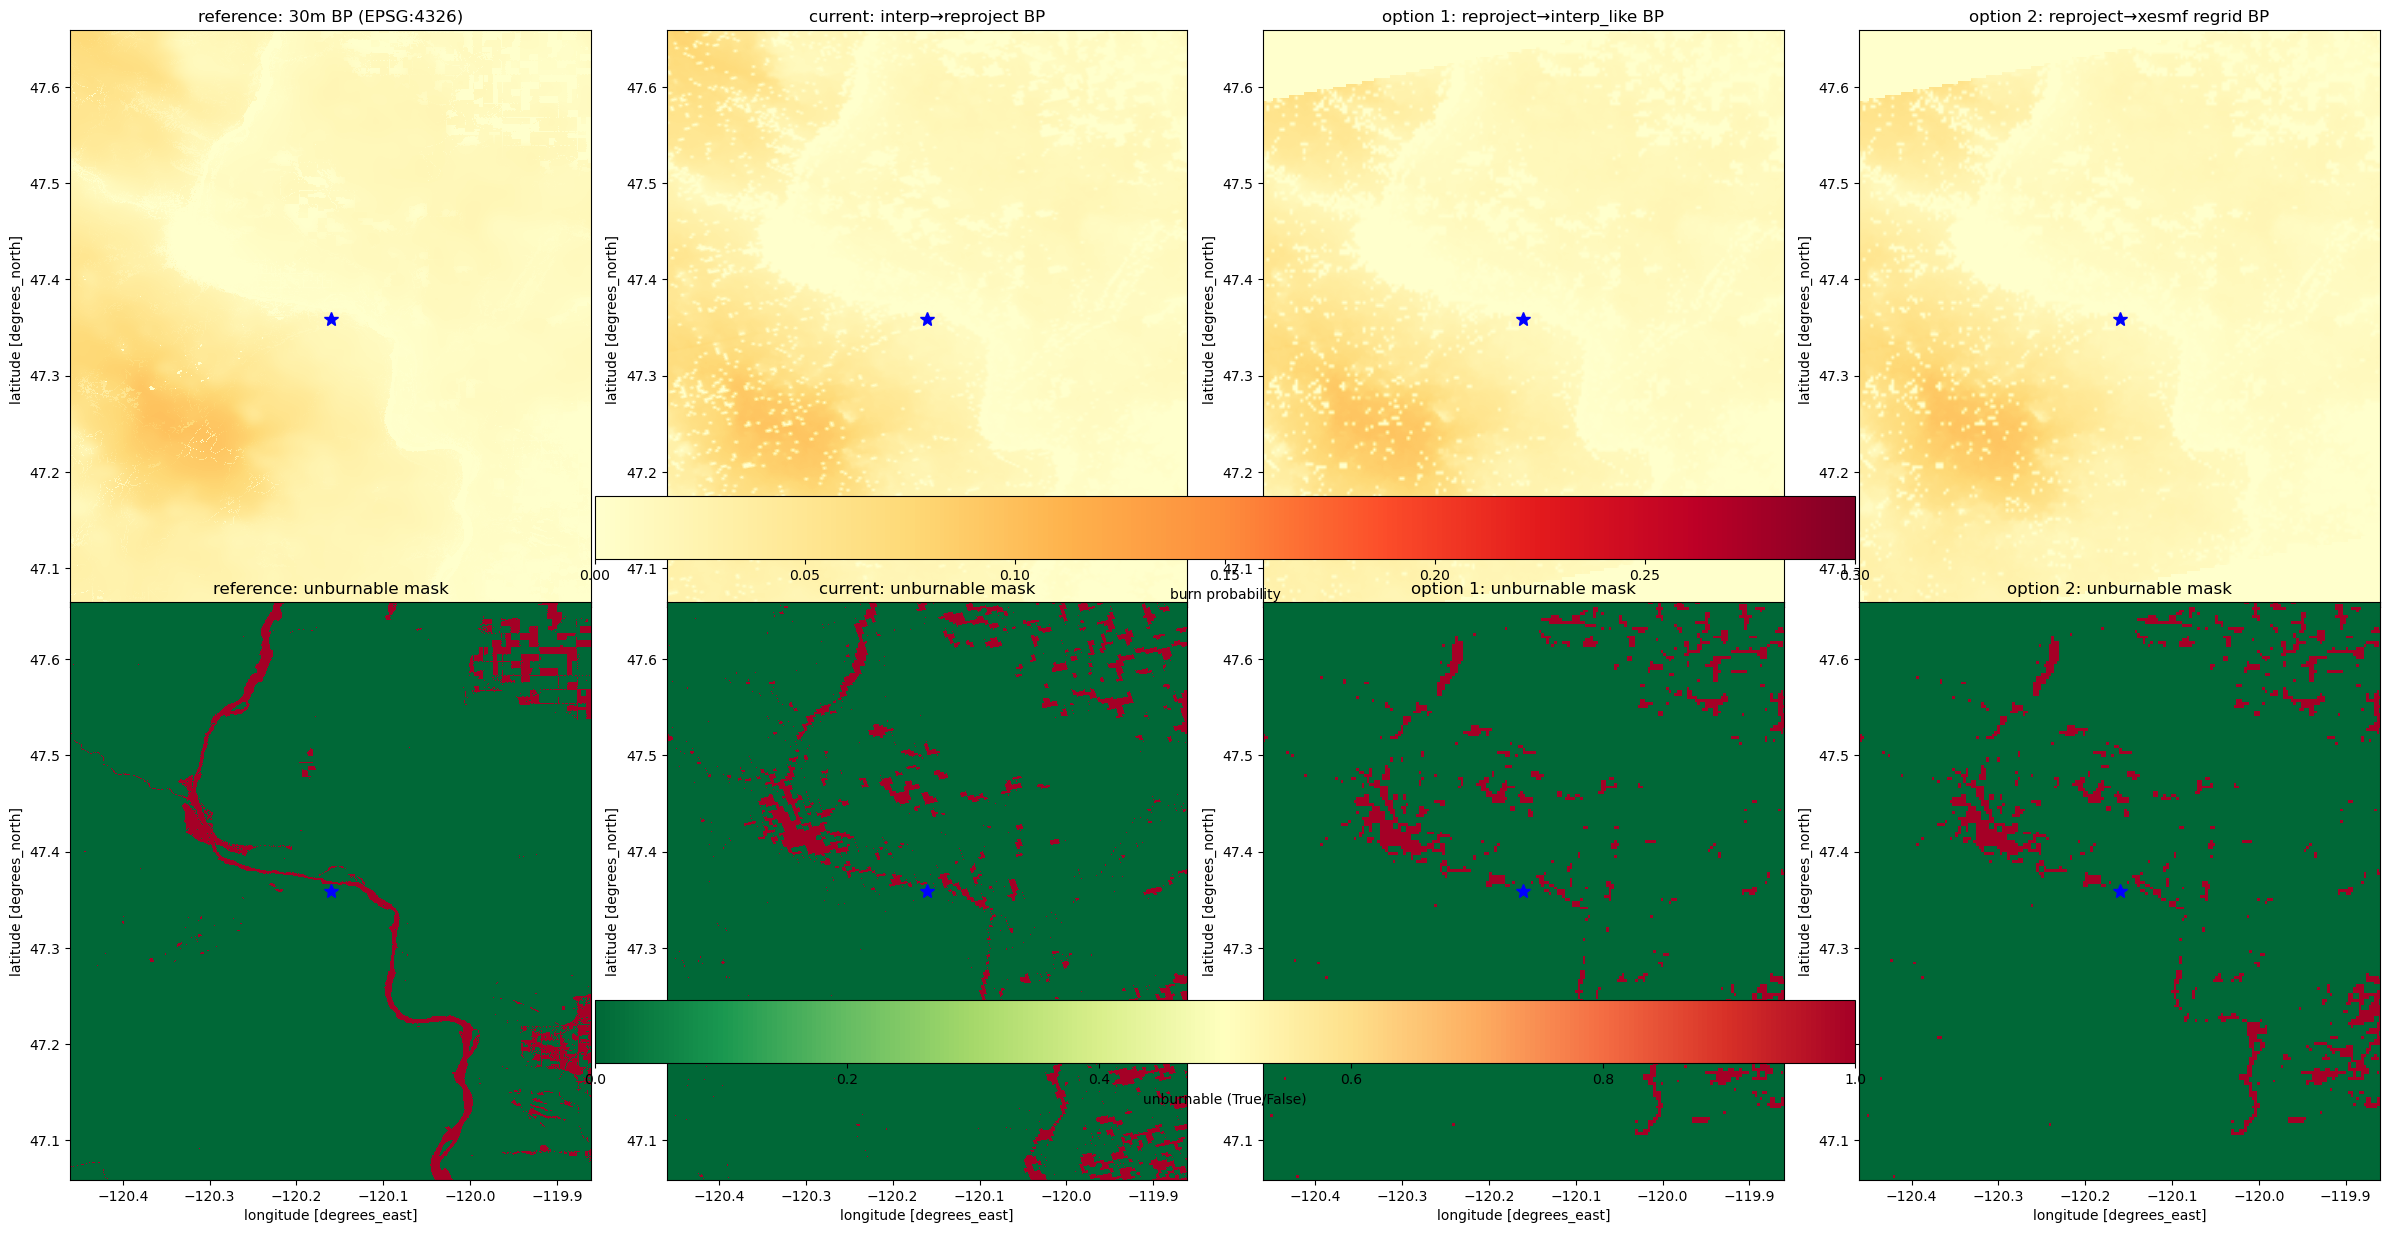

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# row 1: BP values
# reference
im0 = rps_30_subset.BP.plot(ax=axes[0, 0], cmap='YlOrRd', vmin=0, vmax=0.3, add_colorbar=False)
axes[0, 0].plot(lng, lat, 'b*', markersize=10)
axes[0, 0].set_title('reference: 30m BP (EPSG:4326)')

# current
im1 = current_30_4326_subset.BP.plot(
    ax=axes[0, 1], cmap='YlOrRd', vmin=0, vmax=0.3, add_colorbar=False
)
axes[0, 1].plot(lng, lat, 'b*', markersize=10)
axes[0, 1].set_title('current: interp→reproject BP')

# option 1
im2 = option1_30_4326.BP.plot(ax=axes[0, 2], cmap='YlOrRd', vmin=0, vmax=0.3, add_colorbar=False)
axes[0, 2].plot(lng, lat, 'b*', markersize=10)
axes[0, 2].set_title('option 1: reproject→interp_like BP')

# option 2
im3 = option2_30_4326.BP.plot(ax=axes[0, 3], cmap='YlOrRd', vmin=0, vmax=0.3, add_colorbar=False)
axes[0, 3].plot(lng, lat, 'b*', markersize=10)
axes[0, 3].set_title('option 2: reproject→xesmf regrid BP')

# add colorbar for row 1
plt.colorbar(im3, ax=axes[0, :], orientation='horizontal', pad=0.05, label='burn probability')

# row 2: unburnable masks
# reference
mask_ref = rps_30_subset.BP == 0
im4 = mask_ref.plot(ax=axes[1, 0], cmap='RdYlGn_r', add_colorbar=False)
axes[1, 0].plot(lng, lat, 'b*', markersize=10)
axes[1, 0].set_title('reference: unburnable mask')

# current
im5 = unburnable_mask_current.plot(ax=axes[1, 1], cmap='RdYlGn_r', add_colorbar=False)
axes[1, 1].plot(lng, lat, 'b*', markersize=10)
axes[1, 1].set_title('current: unburnable mask')

# option 1
im6 = unburnable_mask_option1.plot(ax=axes[1, 2], cmap='RdYlGn_r', add_colorbar=False)
axes[1, 2].plot(lng, lat, 'b*', markersize=10)
axes[1, 2].set_title('option 1: unburnable mask')

# option 2
im7 = unburnable_mask_option2.plot(ax=axes[1, 3], cmap='RdYlGn_r', add_colorbar=False)
axes[1, 3].plot(lng, lat, 'b*', markersize=10)
axes[1, 3].set_title('option 2: unburnable mask')

# add colorbar for row 2
plt.colorbar(
    im7, ax=axes[1, :], orientation='horizontal', pad=0.05, label='unburnable (True/False)'
)

plt.tight_layout()
plt.show()

## quantitative comparison

In [15]:
# count unburnable pixels
ref_unburnable_count = mask_ref.sum().values
current_unburnable_count = unburnable_mask_current.sum().values
option1_unburnable_count = unburnable_mask_option1.sum().values
option2_unburnable_count = unburnable_mask_option2.sum().values

print(f'reference unburnable pixels: {ref_unburnable_count:,}')
print(
    f'current   unburnable pixels: {current_unburnable_count:,} ({current_unburnable_count / ref_unburnable_count * 100:.1f}% of reference)'
)
print(
    f'option 1  unburnable pixels: {option1_unburnable_count:,} ({option1_unburnable_count / ref_unburnable_count * 100:.1f}% of reference)'
)
print(
    f'option 2  unburnable pixels: {option2_unburnable_count:,} ({option2_unburnable_count / ref_unburnable_count * 100:.1f}% of reference)'
)

# compare BP statistics
print('\nBP statistics (excluding zeros):')
print(
    f'reference - mean: {rps_30_subset.BP.where(rps_30_subset.BP > 0).mean().values:.6f}, std: {rps_30_subset.BP.where(rps_30_subset.BP > 0).std().values:.6f}'
)
print(
    f'current   - mean: {current_30_4326_subset.BP.where(current_30_4326_subset.BP > 0).mean().values:.6f}, std: {current_30_4326_subset.BP.where(current_30_4326_subset.BP > 0).std().values:.6f}'
)
print(
    f'option 1  - mean: {option1_30_4326.BP.where(option1_30_4326.BP > 0).mean().values:.6f}, std: {option1_30_4326.BP.where(option1_30_4326.BP > 0).std().values:.6f}'
)
print(
    f'option 2  - mean: {option2_30_4326.BP.where(option2_30_4326.BP > 0).mean().values:.6f}, std: {option2_30_4326.BP.where(option2_30_4326.BP > 0).std().values:.6f}'
)

reference unburnable pixels: 170,319
current   unburnable pixels: 221,746 (130.2% of reference)
option 1  unburnable pixels: 169,629 (99.6% of reference)
option 2  unburnable pixels: 169,629 (99.6% of reference)

BP statistics (excluding zeros):
reference - mean: 0.023869, std: 0.021517
current   - mean: 0.022695, std: 0.020831
option 1  - mean: 0.022590, std: 0.020600
option 2  - mean: 0.022590, std: 0.020600


## difference maps

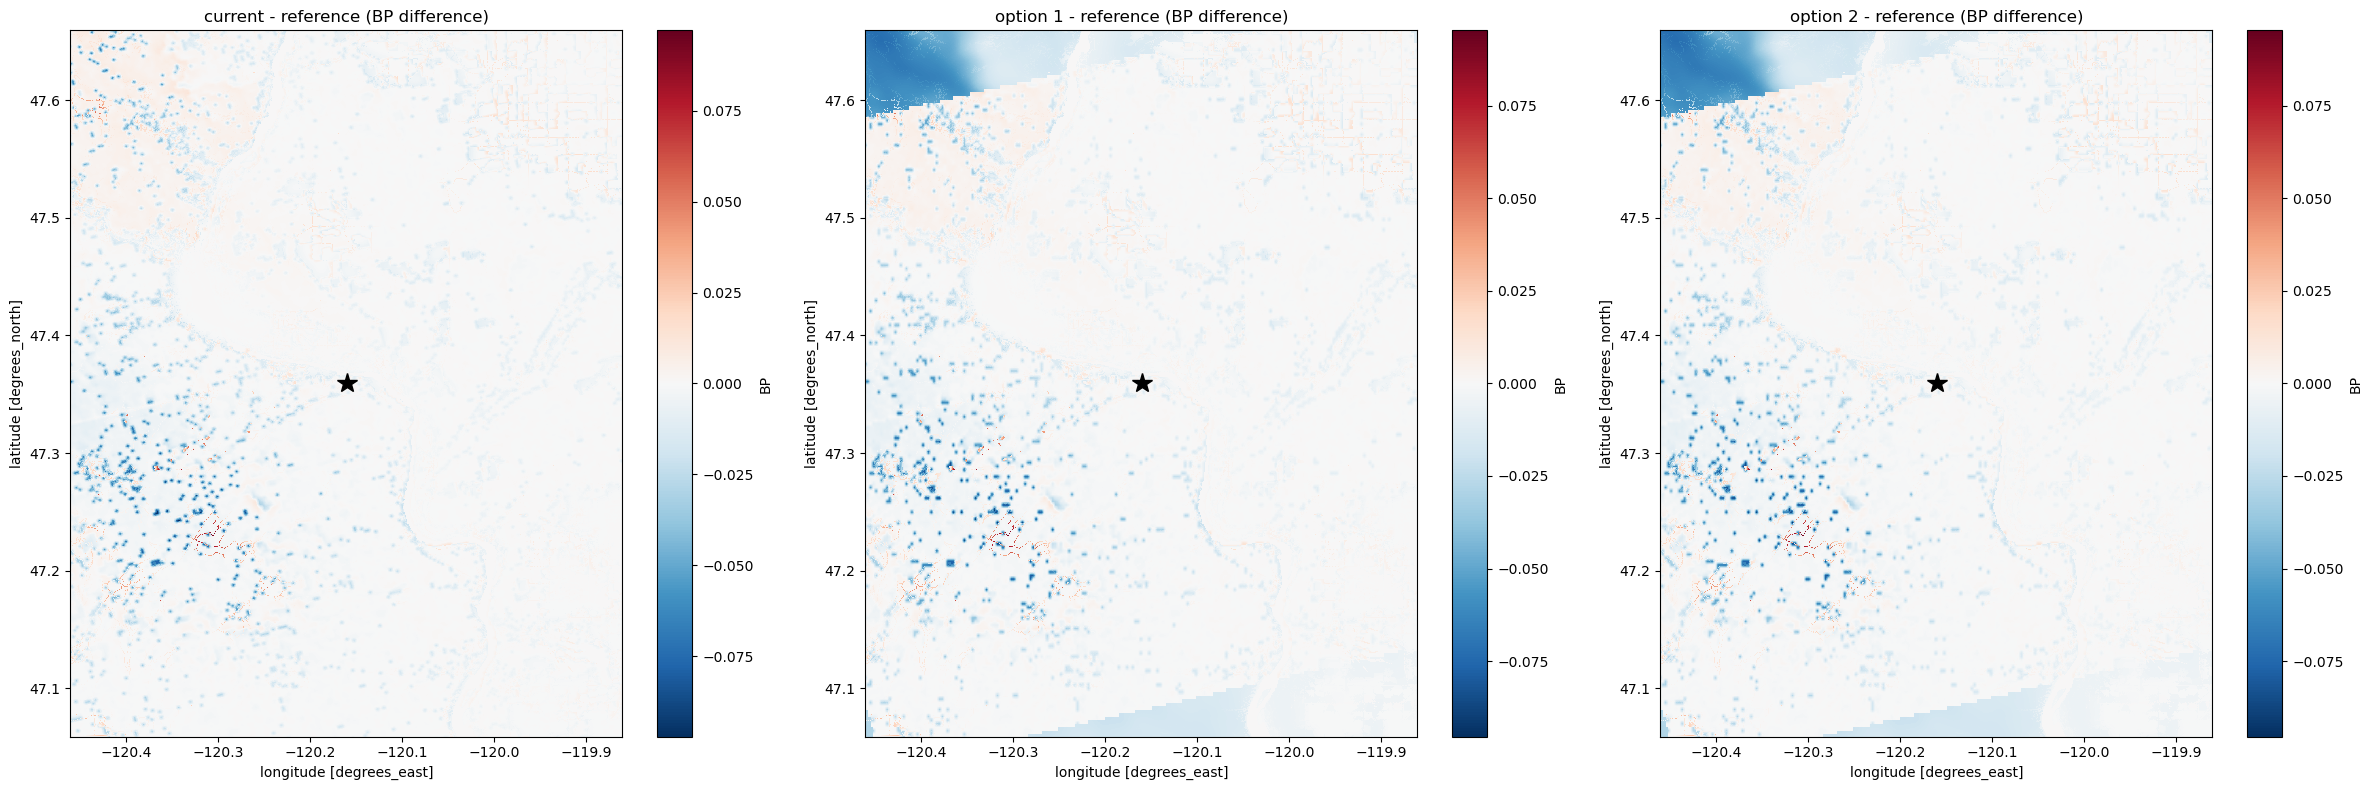

current  - RMSE: 0.006255
option 1 - RMSE: 0.010847
option 2 - RMSE: 0.010847


In [16]:
# calculate differences
diff_current = current_30_4326_subset.BP - rps_30_subset.BP
diff_option1 = option1_30_4326.BP - rps_30_subset.BP
diff_option2 = option2_30_4326.BP - rps_30_subset.BP

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# current difference
vmax = max(abs(diff_current.min().values), abs(diff_current.max().values))
diff_current.plot(ax=axes[0], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[0].plot(lng, lat, 'k*', markersize=15)
axes[0].set_title('current - reference (BP difference)')

# option 1 difference
vmax = max(abs(diff_option1.min().values), abs(diff_option1.max().values))
diff_option1.plot(ax=axes[1], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[1].plot(lng, lat, 'k*', markersize=15)
axes[1].set_title('option 1 - reference (BP difference)')

# option 2 difference
vmax = max(abs(diff_option2.min().values), abs(diff_option2.max().values))
diff_option2.plot(ax=axes[2], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[2].plot(lng, lat, 'k*', markersize=15)
axes[2].set_title('option 2 - reference (BP difference)')

plt.tight_layout()
plt.show()

print(f'current  - RMSE: {np.sqrt((diff_current**2).mean().values):.6f}')
print(f'option 1 - RMSE: {np.sqrt((diff_option1**2).mean().values):.6f}')
print(f'option 2 - RMSE: {np.sqrt((diff_option2**2).mean().values):.6f}')